In [8]:
import os
import os.path as op
import glob
import numpy as np
import pandas as pd
from pandas import DataFrame
import nibabel as nib
import scipy
import matplotlib
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests, _ecdf as ecdf, fdrcorrection as fdrcorrection0, fdrcorrection_twostage
%matplotlib inline

In [9]:
#preliminary housekeeping
home_dir = '/data/home/iballard/mag/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
runs = map(str,range(1,5))

In [10]:
sns.set_context('paper',font_scale = 2.5)
sns.set(font="Times New Roman")
sns.set_style("white")

In [77]:
smoothing = 'smoothed'
regspace = 'epi'

exp = 'mag-SVtotaldiff'

rois = ['_amfg',
        '_pmfg',
        '_fpc',
        '_ifg',
        '_psfs',
        '_ifs',
       '_ains',
       'h.vmpfc']

In [78]:
def extract_copes(exp,regspace,smoothing,contrast):
    df = pd.DataFrame(columns=('sub','contrast','mask_vox','hemi','label','value'))

    for sub in subs:
        cope = home_dir + '/analysis/' + exp + '/' + sub + '/ffx/' + regspace + \
            '/' + smoothing + '/' + contrast + '/cope1.nii.gz'
        cope = nib.load(cope).get_data()

        masks = glob.glob(home_dir + '/data/' + sub + '/masks/*.*nii.gz')
        masks = [m for m in masks if any(substring in m for substring in rois)]

        for m in masks:
            if len(m.split('/')[-1].split('.'))==4:
                hemi = m.split('/')[-1].split('.')[0]
                label = m.split('/')[-1].split('.')[1]
            else:
                hemi = 'na'
                label = m.split('/')[-1].split('.')[0]

            m = nib.load(m).get_data().astype(bool)
            num_voxels = m.sum()
            func_masked = cope[m]
            row = pd.DataFrame([dict(sub = sub, 
                                     contrast =contrast, 
                                     mask_vox = num_voxels, 
                                     hemi = hemi,
                                     label = label, 
                                     value = func_masked.mean()), ])
            df = df.append(row, ignore_index = True)
    return df

In [79]:
def plot_fig(df,contrast):
    plt.figure(figsize=(4, 8))
    sns.factorplot(x='ROI', y='value', col='contrast', 
                   aspect=2, kind='bar',ci=68, 
                   units='sub', data=df,
                   palette = custom_palette,
                  x_order = roi_plotting_order)
    plt.ylabel('Beta (AU)')
    plt.title(title_map[contrast])
#     plt.savefig('/home/iballard/Dropbox/mag_figs/' + contrast + '.svg')

In [80]:
def run_stats(df):
    results_df =pd.DataFrame(columns=('contrast','label','nvox','std_vox','p_unc'))
    for roi in set(df['label']):
        vals = df.ix[df['label'] == roi,'value'].values
        vox = df.ix[df['label'] == roi,'mask_vox'].values

        t,p = scipy.stats.wilcoxon(vals)
        
        
        row = pd.DataFrame([dict(contrast = contrast, 
                                 label = roi,
                                 nvox = np.mean(vox),
                                 std_vox = np.std(vox),
                                p_unc = p), ])
        results_df = results_df.append(row, ignore_index = True)
    sig,pcorr = fdrcorrection0(results_df['p_unc'],.05)
    results_df['p_corr'] = pcorr
    results_df['sig'] = sig
    return results_df

In [81]:
label_map = {'yeo17_amfg':'aMFG','yeo17_pmfg':'pMFG','yeo17_ains':'aINS','yeo17_fpc':'FPC',
            'yeo17_ifs':'IFS','yeo17_ifg':'IFG','yeo17_psfs':'FEF','vmpfc_bartre':'vmPFC'}
roi_plotting_order = ['IFS','FPC','pMFG','FEF','aINS','IFG','aMFG','vmPFC']

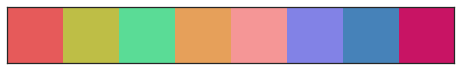

In [82]:
#get colors from ROI figure and match them
ctab = '/home/iballard/mag/data/fsaverage/label/pfc.ctab'
color = np.loadtxt(ctab,object)
custom_palette = []
for row in color:
    rgb = (int(row[2]),int(row[3]),int(row[4]))
    hex_rgb = '#%02x%02x%02x' % rgb
    roi_id = label_map[row[1]]
    custom_palette.append((hex_rgb, roi_id))

custom_palette.sort(key=lambda x: roi_plotting_order.index(x[1]))
custom_palette = [x[0] for x in custom_palette]

sns.set_palette(custom_palette)
sns.palplot(sns.color_palette())

In [83]:
def run_contrast(exp,regspace,smoothing,contrast):
    df = extract_copes(exp,regspace,smoothing,contrast)
    df['ROI'] = [label_map[x] for x in df['label'].values]
    
    df.to_csv('/home/iballard/Dropbox/Magnitude_fMRI/roi_analysis/' + exp  + '_' + contrast + '.csv',
              index = False)
    
    plot_fig(df,contrast)
    results = run_stats(df)
    
    return results

In [84]:
contrasts = ['decision',
             'SV_total',
             'neg_SV_diff',
             'low_minus_high_SV_diff',
             'high_minus_low_SV',
            'high_minus_low']
title_map = {'decision': 'Decision Period',
             'SV_total': 'Subjective Value',
             'neg_SV_diff': 'Difficulty',
             'low_minus_high_SV_diff': 'Difficulty (High minus Low Magnitude)',
             'high_minus_low_SV': 'Subjective Value (High minus Low Magnitude)',
            'high_minus_low': 'High minus Low Magnitude'}


In [89]:
all_results = []

for contrast in contrasts:
    results = run_contrast(exp,regspace,smoothing,contrast)
    all_results.append(results.copy())
    
all_results = pd.concat(all_results)
all_results = all_results.set_index(['contrast'])